### 3-2. 파라미터 튜닝
- 3-1을 통해 머신러닝을 통한 예측의 가능성을 보여준 채소들을 중심으로 파라미터 튜닝
- score가 높았던 randomforest, gradientboosting, xgboost를 중심으로 튜닝

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

import xgboost

import warnings
warnings.filterwarnings('ignore')

In [37]:
def get_climate_data(vege) :
    dome = False
    fore = False
    if f'{vege}_na.csv' in os.listdir('./data/climate_final/국내') :
        climate_domestic = pd.read_csv(f'./data/climate_final/{vege}_na.csv',
                                             index_col = 0,
                                             parse_dates = True,
                                             encoding = 'cp949')
        dome = True
    if f'{vege}_for.csv' in os.listdir('./data/climate_final/해외') :
        climate_foreign = pd.read_csv(f'./data/climate_final/해외/{vege}_for.csv',
                                         index_col = 0,
                                         parse_dates = True,
                                         encoding = 'cp949')
        fore = True
    if dome and fore :
        merged_climate = pd.merge(climate_foreign, climate_domestic, left_index = True, right_index = True)
        return merged_climate.loc['2011':]
    elif dome :
        return climate_domestic.loc['2011':]
    else :
        return climate_foreign.loc['2011':]

In [38]:
def get_price_data(vege, anually = False, rank = '중품'):
    if vege == '마늘' :
        vege = '피' + vege
    elif vege == '고추':
        vege = '풋' + vege
    prices = pd.read_csv('./data/vegetable_price.csv',
                               index_col = 1,
                               parse_dates = True,
                               encoding = 'cp949')
    price_columns = ['Name', 'SubCategory', 'Rank', 'Category', 'Price']
    prices.drop(['Unnamed: 0'], axis = 1, inplace = True)
    prices.columns = price_columns
    prices = prices.sort_values('0')
    if anually :
        df = prices[(prices.Name == vege) & (prices.Category == '평년') & (prices.Rank == rank)]
        return df['2011':]
    else :
        df = prices[(prices.Name == vege) & (prices.Category == '전국평균') & (prices.Rank == rank)]
        return df['2011':]

In [39]:
null_breaker = {
#     '상추' : ['203','236'],
#     '시금치' : [ 'Steam', 'Ap']
}

In [40]:
vege_name = '상추'

In [41]:
climate_df = get_climate_data(vege_name)
price_df = get_price_data(vege_name)

if vege_name in null_breaker.keys():
    dead_column = []
    for column in climate_df.columns :

        for eliminate in null_breaker[vege_name] :
            if eliminate in column :
                dead_column.append(column)

    climate_df.drop(dead_column, axis = 1, inplace = True)

In [42]:
climate_df['month'] = climate_df.index.month

In [43]:
price_df = price_df[price_df.SubCategory == '적상추']

In [44]:
price_df.tail(20)

,Name,SubCategory,Rank,Category,Price
0,,,,,
2021-09-13,상추,적상추,중품,전국평균,47000
2021-09-14,상추,적상추,중품,전국평균,61300
2021-09-15,상추,적상추,중품,전국평균,77300
2021-09-16,상추,적상추,중품,전국평균,78000
2021-09-17,상추,적상추,중품,전국평균,69600
2021-09-23,상추,적상추,중품,전국평균,69600
2021-09-24,상추,적상추,중품,전국평균,27300
2021-09-27,상추,적상추,중품,전국평균,16000
2021-09-28,상추,적상추,중품,전국평균,13600


In [45]:
merged_df = pd.concat([climate_df.loc[price_df.index[0] : price_df.index[-1]], price_df.Price], axis = 1).ffill()

In [68]:
X = merged_df.drop('Price', axis = 1)
y = merged_df.Price

In [69]:
X_train = X.loc[:'2018-12-31', :]
y_train = y.loc[:'2018-12-31']

In [70]:
X_test = X.loc['2019-1-1':, :]
y_test = y.loc['2019-1-1':]

In [71]:
X

,m_Temp_114,m_Rainfall_114,m_WindSpeed_114,m_Humidity_114,m_SteamPressure_114,m_LandAp_114,m_SeaAp_114,m_Sunshine_114,m_Snow_114,m_LandTemp_114,...,a_SteamPressure_236,a_LandAp_236,a_SeaAp_236,a_Sunshine_236,a_Snow_236,a_LandTemp_236,TempMin_236,TempMax_236,Freeze_236,month
2011-01-03,-8.758333,0.0,0.9,74.250000,2.350000,1005.900000,1025.600000,0.625,0.0,-6.658333,...,3.058333,1020.950000,1022.350000,0.442857,0.0,0.066667,-11.9,1.2,0,1
2011-01-04,-6.091667,0.0,1.3,74.750000,2.908333,1003.333333,1022.783333,0.525,0.0,-5.025000,...,4.550000,1021.025000,1022.425000,0.057143,0.0,0.133333,-10.4,0.3,0,1
2011-01-05,-1.775000,0.1,2.2,67.000000,3.616667,1001.883333,1020.975000,0.000,0.2,-1.450000,...,3.600000,1020.958333,1022.358333,0.185714,0.0,0.158333,-1.1,2.4,0,1
2011-01-06,-8.091667,0.0,2.2,67.250000,2.250000,1005.191667,1024.833333,0.525,0.0,-7.100000,...,2.441667,1025.825000,1027.225000,0.800000,0.0,-0.075000,-3.9,-0.4,0,1
2011-01-07,-12.108333,0.0,1.6,70.166667,1.683333,1010.050000,1030.100000,0.675,0.0,-9.416667,...,2.408333,1027.258333,1028.675000,0.828571,0.0,-0.258333,-12.5,0.6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,14.700000,3.2,1.2,85.750000,14.258333,1002.941667,1020.783333,0.140,0.0,18.250000,...,15.133333,1020.175000,1021.775000,0.025000,0.0,19.841667,12.6,17.5,0,10
2021-10-12,17.008333,0.0,1.2,70.250000,13.525000,1006.533333,1024.250000,0.000,0.0,17.775000,...,15.866667,1024.091667,1025.691667,0.000000,0.0,18.391667,15.7,17.0,0,10
2021-10-13,15.333333,0.0,1.5,78.833333,13.508333,1008.308333,1026.175000,0.720,0.0,17.300000,...,18.433333,1021.683333,1023.266667,0.485714,0.0,23.550000,16.0,24.3,0,10
2021-10-14,16.825000,0.0,2.5,82.666667,15.733333,1004.008333,1021.716667,0.480,0.0,18.333333,...,16.808333,1018.025000,1019.575000,0.828571,0.0,23.566667,14.2,25.7,0,10


In [72]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [112]:
knn = KNeighborsRegressor()
linear = LinearRegression()
ridge = Ridge()
# lasso = Lasso()
eln = ElasticNet()
lr = LogisticRegression()
rfc = RandomForestRegressor()
# gbr = GradientBoostingRegressor()
# xgb = xgboost.XGBRegressor()

##############################################################################

# knn = KNeighborsRegressor()
# linear = LinearRegression()
# ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 10)
# eln = ElasticNet()
# lr = LogisticRegression()
# rfc = RandomForestRegressor(n_estimators = 200,
#                             max_features = 'auto',
#                             max_depth = 9, 
#                             min_samples_split=0.05)
gbr = GradientBoostingRegressor(learning_rate = 0.1,
                               max_features = 9)
xgb = xgboost.XGBRegressor(learning_rate = 0.1,
                           max_depth = 3,
                           booster = 'dart')

In [113]:
models = [knn, linear, ridge, lasso,eln, rfc, gbr, xgb]
# models = [knn, linear, ridge, lasso, rfc, gbr, xgb]

In [114]:
for model in models :
    print('====================================')
    print(type(model).__name__)
    model.fit(X_train_scaled, y_train)
    print('train:', model.score(X_train_scaled, y_train))
    print('test:', model.score(X_test_scaled, y_test))
    print()
    y_preds = model.predict(X_test_scaled)
    print('explained_variance_score:', explained_variance_score(y_test, y_preds))
    print('mean_squared_error:', mean_squared_error(y_test, y_preds))
    print('r2_score:', r2_score(y_test, y_preds))

KNeighborsRegressor
train: 0.5076236526567371
test: 0.23139985285905262

explained_variance_score: 0.27606083714209495
mean_squared_error: 171350634.05299312
r2_score: 0.23139985285905262
LinearRegression
train: 0.392545900888435
test: -0.964004958189375

explained_variance_score: 0.20459566771774762
mean_squared_error: 437852498.6246945
r2_score: -0.964004958189375
Ridge
train: 0.3745402753614129
test: 0.3777109571639202

explained_variance_score: 0.38953585565609394
mean_squared_error: 138732242.57220775
r2_score: 0.3777109571639202
Lasso
train: 0.3620966721389859
test: 0.4021596656703492

explained_variance_score: 0.4055857256897527
mean_squared_error: 133281681.93943028
r2_score: 0.4021596656703492
ElasticNet
train: 0.24524291152564115
test: 0.27182113359242666

explained_variance_score: 0.3098094117447838
mean_squared_error: 162339170.66899312
r2_score: 0.27182113359242666
RandomForestRegressor
train: 0.9285406589011587
test: 0.41545365982431604

explained_variance_score: 0.435664

## Tuning

In [22]:
from sklearn.model_selection import GridSearchCV

### Ridge

In [23]:
params = {
    'alpha' : [ 100, 10, 1, 0.1, 0.01]
}

In [24]:
grid = GridSearchCV(ridge, params)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [100, 10, 1, 0.1, 0.01]})

In [25]:
grid.best_params_

{'alpha': 1}

In [26]:
print('r2_score:', r2_score(y_test, grid.predict(X_test_scaled)))

r2_score: 0.3777109571639202


### Lasso

In [27]:
params = {
    'alpha' : [10, 1, 0.1, 0.01]
}

In [28]:
grid = GridSearchCV(lasso, params)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Lasso(alpha=10),
             param_grid={'alpha': [10, 1, 0.1, 0.01]})

In [29]:
grid.best_params_

{'alpha': 10}

In [30]:
print('r2_score:', r2_score(y_test, grid.predict(X_test_scaled)))

r2_score: 0.4021596656703492


### RandomForestRegressor

In [31]:
params = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : [6, 9, None],
    'min_samples_split': [0.01, 0.05, 0.1],
    'max_features' : ['auto', 'sqrt'],
}

In [32]:
grid = GridSearchCV(rfc, params)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 9, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 150, 200]})

In [33]:
grid.best_params_

{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_split': 0.05,
 'n_estimators': 200}

In [34]:
print('r2_score:', r2_score(y_train, grid.predict(X_train_scaled)))
print('r2_score:', r2_score(y_test, grid.predict(X_test_scaled)))

r2_score: 0.4553840732343184
r2_score: 0.40071641028149985


### GradientBoostingRegressor

In [96]:
params = {
    'learning_rate' : [1, 0.1, 0.01],
    'max_features' : [3, 6, 9, None]
}

In [97]:
grid = GridSearchCV(gbr, params, scoring = 'neg_mean_absolute_error')
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'max_features': [3, 6, 9, None]},
             scoring='neg_mean_absolute_error')

In [98]:
grid.best_params_

{'learning_rate': 0.1, 'max_features': 9}

In [99]:
print('r2_score:', r2_score(y_train, grid.predict(X_train_scaled)))
print('r2_score:', r2_score(y_test, grid.predict(X_test_scaled)))

r2_score: 0.6394432402740245
r2_score: 0.45131443781255


### XGBOOST Rregressor

In [76]:
params = {
    'booster' : ['dart', 'gbtree'],
    'learning_rate' : [1, 0.1, 0.01],
    'max_depth' : [3, 6, 9, 12],
}

In [77]:
grid = GridSearchCV(xgb, params, scoring = 'neg_mean_absolute_error')
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,

In [78]:
grid.best_params_

{'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 3}

In [81]:
print('r2_score:', r2_score(y_train, grid.predict(X_train_scaled)))
print('r2_score:', r2_score(y_test, grid.predict(X_test_scaled)))

r2_score: 0.662428929903478
r2_score: 0.41698616881963957


## VotingRegressor

In [115]:
from sklearn.ensemble import VotingRegressor

In [181]:
# 0.82 / 0.46
voting = VotingRegressor([('ridge', ridge), ('lasso', lasso), ('rfc', rfc), ('gbr', gbr), ('xgb', xgb)],
                        weights = [1, 1, 7, 2, 1])

In [182]:
voting.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('ridge', Ridge()), ('lasso', Lasso(alpha=10)),
                            ('rfc', RandomForestRegressor()),
                            ('gbr', GradientBoostingRegressor(max_features=9)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='dart',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=nan,
                                          monotone_con

In [183]:
print(voting.score(X_train_scaled, y_train))
print(voting.score(X_test_scaled, y_test))

0.8273504501892003
0.4616421904452054


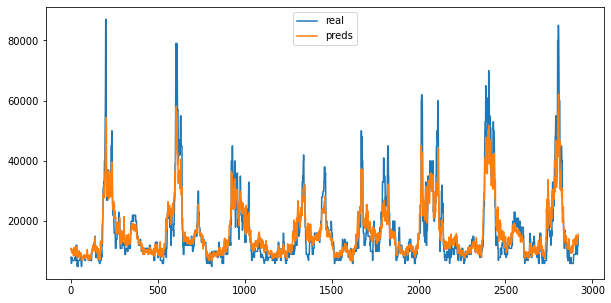

In [184]:
y_preds = voting.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

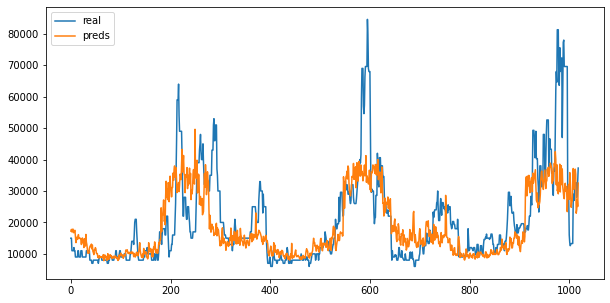

In [185]:
y_preds = voting.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

### KNeighbors 그래프 확인

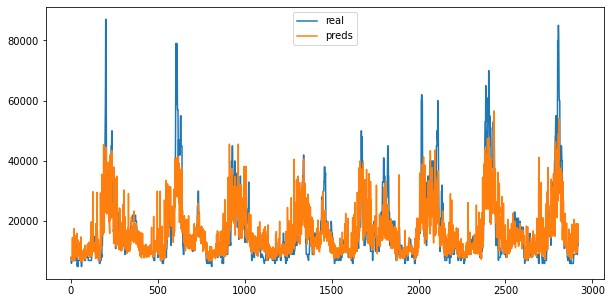

In [121]:
y_preds = knn.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

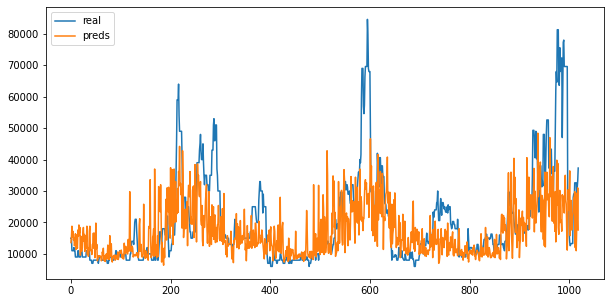

In [122]:
y_preds = knn.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

### Ridge 그래프 확인

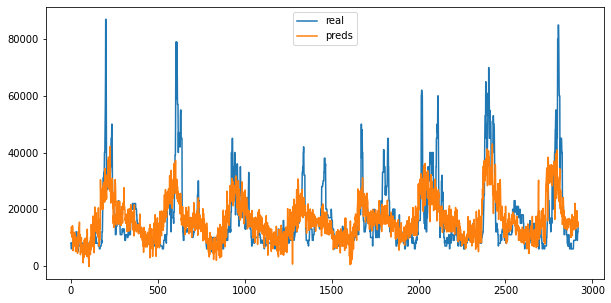

In [123]:
y_preds = ridge.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

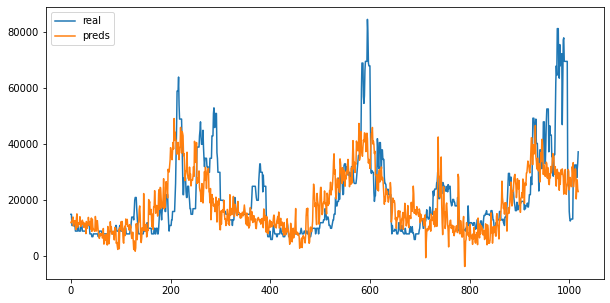

In [124]:
y_preds = ridge.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

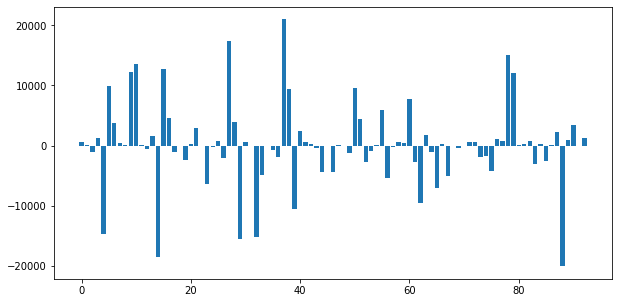

In [125]:
plt.figure(figsize = (10, 5))
plt.bar(range(len(ridge.coef_)), ridge.coef_)
plt.show()

### RandomForest 그래프 확인

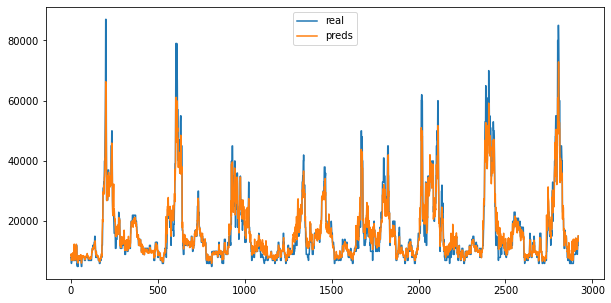

In [126]:
y_preds = rfc.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

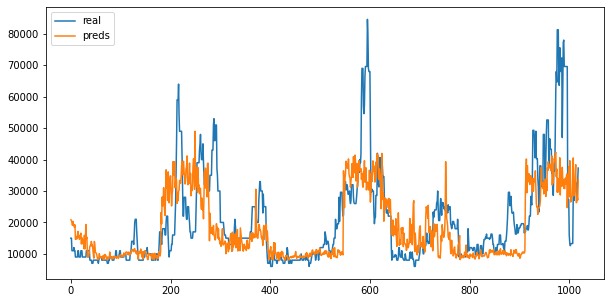

In [127]:
y_preds = rfc.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

In [128]:
rfc.feature_importances_

array([4.50465181e-03, 3.27886701e-03, 1.14666696e-02, 1.30615688e-02,
       1.28773836e-02, 3.06499094e-03, 3.18503474e-03, 7.74501957e-03,
       8.67715491e-04, 1.23343126e-02, 4.41861074e-03, 1.59323890e-03,
       1.05309709e-02, 8.90033781e-03, 2.10468574e-02, 3.31001974e-03,
       3.06850444e-03, 7.44353079e-03, 8.15985024e-04, 9.18182433e-03,
       3.75518275e-03, 4.53438984e-03, 0.00000000e+00, 3.85083498e-03,
       1.76686225e-03, 9.88781555e-03, 1.69584603e-02, 3.36646141e-02,
       2.61214666e-03, 2.23791219e-03, 4.83747044e-03, 5.83118103e-03,
       1.82029720e-02, 4.01021691e-03, 1.42307082e-03, 8.24868597e-03,
       1.03492289e-02, 4.02110342e-02, 2.69558776e-03, 2.80777138e-03,
       6.36861211e-03, 4.07959019e-03, 1.01688763e-02, 3.57727808e-03,
       2.74353424e-03, 0.00000000e+00, 4.15104983e-03, 2.29133462e-03,
       8.53308834e-03, 1.42638832e-02, 1.76672555e-02, 3.44890365e-03,
       4.49825847e-03, 9.52139478e-03, 4.32606298e-05, 1.61380339e-02,
      

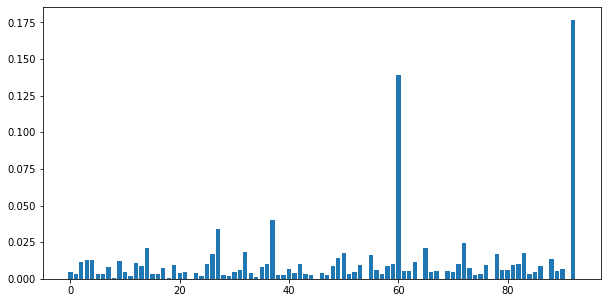

In [129]:
plt.figure(figsize = (10, 5))
plt.bar(range(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.show()

### GradientBoosting 그래프 확인

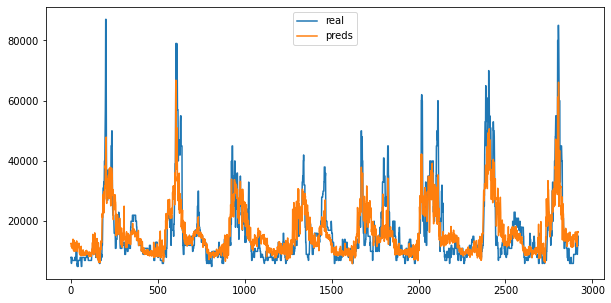

In [130]:
y_preds = gbr.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

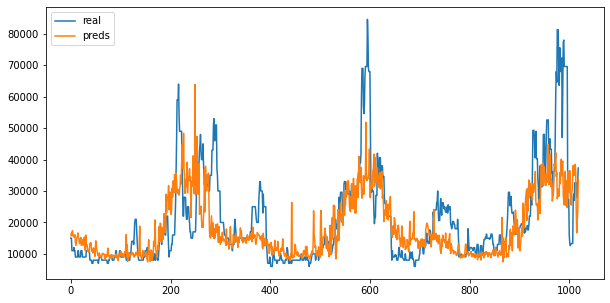

In [131]:
y_preds = gbr.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

In [132]:
gbr.feature_importances_

array([0.00890824, 0.00297545, 0.00058252, 0.00544506, 0.05935598,
       0.00101887, 0.00316249, 0.00329157, 0.        , 0.01434219,
       0.00156909, 0.00128562, 0.00684091, 0.00928479, 0.03710058,
       0.00708116, 0.00223586, 0.00131828, 0.        , 0.00793944,
       0.00161305, 0.00448601, 0.        , 0.00241732, 0.00223361,
       0.01529795, 0.03069124, 0.01676529, 0.00230737, 0.00166184,
       0.00020396, 0.0048938 , 0.01439617, 0.01016682, 0.00464882,
       0.00306238, 0.01509178, 0.11092447, 0.0056135 , 0.00181455,
       0.00268875, 0.00167381, 0.00567263, 0.00413723, 0.00425156,
       0.        , 0.00214322, 0.00147074, 0.00308488, 0.01451   ,
       0.03526907, 0.00467477, 0.00393568, 0.00461395, 0.00035122,
       0.02309078, 0.00350752, 0.00247514, 0.00429997, 0.03565258,
       0.02619776, 0.00630972, 0.00441201, 0.00422809, 0.        ,
       0.03836297, 0.00268657, 0.01343796, 0.        , 0.03346266,
       0.00246183, 0.00496953, 0.01289279, 0.00626375, 0.00569

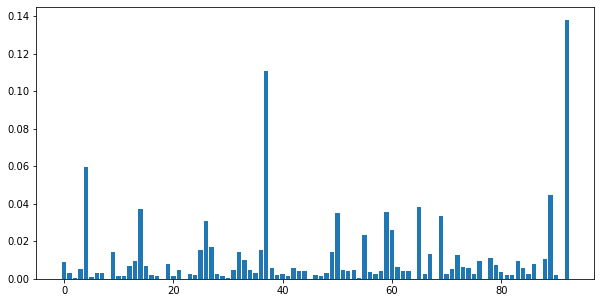

In [133]:
plt.figure(figsize = (10, 5))
plt.bar(range(len(gbr.feature_importances_)), gbr.feature_importances_)
plt.show()

### XGBoost 그래프 확인

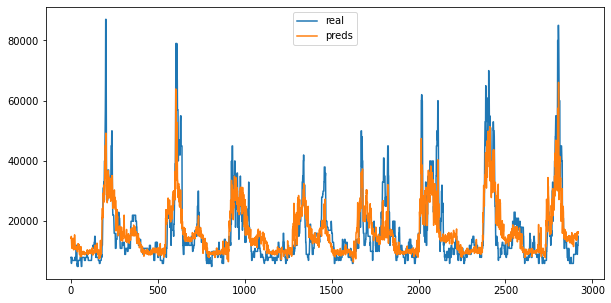

In [134]:
y_preds = xgb.predict(X_train_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_train.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

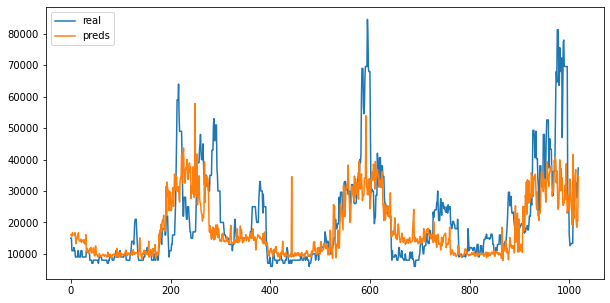

In [135]:
y_preds = xgb.predict(X_test_scaled)
plt.figure(figsize = (10, 5))
plt.plot(y_test.values, label = 'real')
plt.plot(y_preds, label = 'preds')
plt.legend()
plt.show()

In [136]:
xgb.feature_importances_

array([6.2817582e-03, 5.9007234e-03, 9.4480906e-03, 4.0024337e-03,
       1.4319281e-02, 2.5980850e-03, 0.0000000e+00, 1.2545204e-02,
       3.1216568e-03, 9.4165830e-03, 1.0570503e-02, 4.8971102e-03,
       7.3371469e-03, 3.2440247e-03, 1.6259370e-02, 3.5314835e-03,
       0.0000000e+00, 3.3407905e-03, 0.0000000e+00, 9.6881157e-03,
       6.0347700e-03, 1.4485285e-02, 0.0000000e+00, 5.2488232e-03,
       8.8955741e-03, 7.7456092e-03, 1.0952504e-02, 6.0892310e-02,
       6.0736208e-04, 0.0000000e+00, 5.2998266e-03, 8.9082280e-03,
       1.0329263e-02, 9.0801373e-02, 4.4235080e-03, 3.0524787e-03,
       5.1554940e-03, 3.3422541e-02, 0.0000000e+00, 0.0000000e+00,
       4.4471286e-03, 4.8678555e-03, 1.1802041e-02, 1.5613427e-03,
       4.2451294e-03, 0.0000000e+00, 4.0385868e-05, 9.5337918e-03,
       5.1702824e-03, 9.5483372e-03, 1.4379913e-02, 1.2423693e-02,
       2.8535009e-03, 9.6746394e-03, 0.0000000e+00, 7.7558355e-03,
       6.3681444e-03, 2.8129795e-03, 9.1788275e-03, 1.2893804e

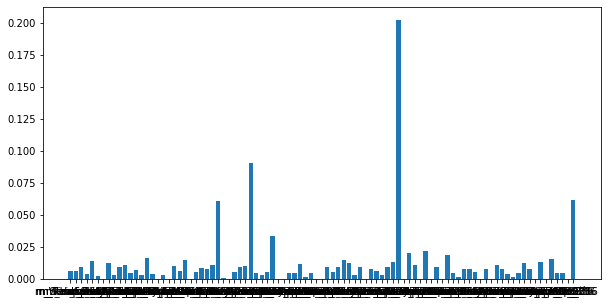

In [137]:
plt.figure(figsize = (10, 5))
plt.bar(X_train.columns, xgb.feature_importances_)
plt.show()